# Aufgabe 5

In [1]:
import numpy as np
from math import pi, cos, sin, radians

### Forward Kinematic (vorherige Aufgabe)

In [2]:
def forward_kinematic_braccio(joint_angles):
    ''' param: joints: current position of all the joints of the braccio '''
    ''' return: current position'''

    result = np.eye(4)
    
    ## initial translation
    result = result @ translation([281, 0, 3])
    
    ## Joint 0 (Base b)
    result = result @ rotate_z(90 - joint_angles[0]) @ translation([0, 0, 71]) 
    
    ## Joint 1 (Shoulder s)
    result = result @ rotate_y(90 - joint_angles[1]) @ translation([0, 0, 126]) 
    
    ## Joint 2 (Elbow e)
    result = result @ rotate_y(90 - joint_angles[2]) @ translation([0, 0, 124]) 
    
    ## Joint 3 (Wrist tilt v)
    result = result @ rotate_y(90 - joint_angles[3]) @ translation([0, 0, 60])

    ## Joint 4 (Wrist rotate w)
    result = result @ rotate_z(90 - joint_angles[4]) @ translation([0, 0, 134]) 
    
    return result

def translation(trans):
    return np.array([
        [1,0,0,trans[0]],
        [0,1,0,trans[1]],
        [0,0,1,trans[2]],
        [0,0,0,1]
    ])

def rotate_z(theta):
    rad = radians(theta)
    return np.array([
        [cos(rad), -sin(rad), 0, 0],
        [sin(rad), cos(rad), 0, 0],
        [0,0,1,0],
        [0,0,0,1]
    ])

def rotate_y(theta):
    rad = radians(theta)
    return np.array([
        [cos(rad),0, sin(rad), 0],
        [0,1,0,0],
        [-sin(rad),0, cos(rad), 0],
        [0,0,0,1]
    ])

def forward_kinematic_braccio_fixed(joint_angles):
    b = joint_angles[0]
    s = 110
    e = joint_angles[1]
    v = joint_angles[2]
    w = 90
    g = 73
    joint_angles_with_fixed = [b, s, e, v, w, g]
    return forward_kinematic_braccio(joint_angles_with_fixed)

In [3]:
result = forward_kinematic_braccio([90, 90, 90, 90, 90, 90])
print(result)

[[  1.   0.   0. 281.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 518.]
 [  0.   0.   0.   1.]]


### Rückwärts Kinematik

In [4]:
def F(x_soll, joint_angles):
    transformation_matrix = forward_kinematic_braccio_fixed(joint_angles)
    x_ist = transformation_matrix[0:3,3]
    return x_ist - x_soll

def dF_theta1(x_soll, joint_angles):
    h = 1E-4
    new_joint_angles = [joint_angles[0]+ h, joint_angles[1], joint_angles[2]]
    return (F(x_soll, new_joint_angles) - F(x_soll, joint_angles)) / h

def dF_theta2(x_soll, joint_angles):
    h = 1E-4
    new_joint_angles = [joint_angles[0], joint_angles[1] + h, joint_angles[2]]
    return (F(x_soll, new_joint_angles) - F(x_soll, joint_angles)) / h

def dF_theta3(x_soll, joint_angles):
    h = 1E-4
    new_joint_angles = [joint_angles[0], joint_angles[1], joint_angles[2] + h]
    return (F(x_soll, new_joint_angles) - F(x_soll, joint_angles)) / h

In [5]:
def jaccobi(x_soll, joint_angles):
    return np.stack((
        dF_theta1(x_soll, joint_angles),
        dF_theta2(x_soll, joint_angles),
        dF_theta3(x_soll, joint_angles)
    ), axis=-1)

def inv_jaccobi(x_soll, joint_angles):
    return np.linalg.pinv(jaccobi(x_soll, joint_angles))

In [6]:
def backward_kinematic_braccio(x_soll, theta_0, max_iter=1000, error=1, alpha=1):
    
    theta_i = theta_0
    errors = []
    
    for i in range(max_iter):
        diff = np.linalg.norm(F(x_soll, theta_i))
        errors.append(diff)
                
        if diff < error:
            return (errors, theta_i)
        
        j_inv = inv_jaccobi(x_soll, theta_i)
        theta_i = theta_i - alpha * j_inv.dot(F(x_soll, theta_i))
        
    raise Exception("Sorry, no solution found") 

In [7]:
x_goal = np.array([0, 100, 100])
theta_0 = np.array([60, 160, 160])
errors, theta_final = backward_kinematic_braccio(x_goal, theta_0)
print(theta_final)

[109.57835424 139.55855642 154.76832722]


In [8]:
forward_kinematic_braccio_fixed(theta_final)[0:3,3]

array([  0.1659969 ,  99.88095763, 100.15056261])

In [9]:
import matplotlib.pyplot as plt

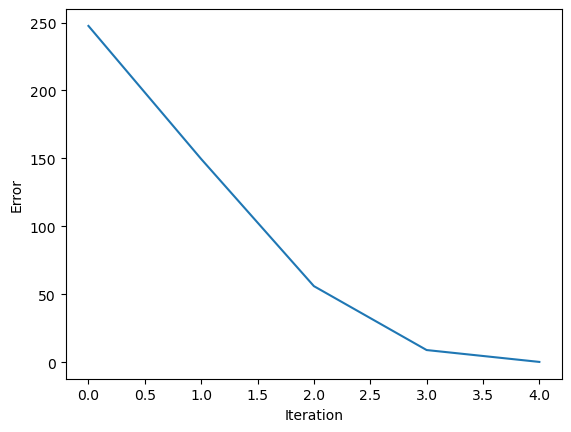

In [10]:
plt.plot(errors)

plt.xlabel("Iteration")
plt.ylabel("Error")

plt.savefig("backward_kinematic.svg")